# ANÁLISIS DE LA VOLATILIDAD

La **volatilidad financiera** es un concepto que hace referencia a la variación del precio o de la rentabilidad de una acción u otro activo financiero a lo largo de un periodo de tiempo.

Volatilidad implica variabilidad, inestabilidad, riesgo, oscilación en la trayectoria de algo durante un tiempo determinado.

Así, si el precio de un activo oscila mucho se dice que es muy volátil.

En el ámbito financiero, la volatilidad indica cuál es la fluctuación de la rentabilidad o del precio de un activo con respecto a su cotización media histórica.

Es un concepto que es de utilidad conocer para la **gestión del riesgo**, ya que a mayor volatilidad de un activo, mayor es el riesgo de que la rentabilidad sea distinta a la esperada.

La volatilidad se expresa como un **porcentaje**, que señala cuánto puede variar la rentabilidad de un activo según su evolución en el pasado

Existen cuatro tipos de volatilidad:

- **Volatilidad histórica**: es la volatilidad que ha tenido un activo en el pasado.

- **Volatilidad implícita**: es la volatilidad que se espera que tenga un activo en el futuro.

- **Volatilidad determinista**: es la volatilidad que se puede calcular a partir de un modelo matemático. Se suele usar la **desviación estándar** de los retornos de un activo.

- **Volatilidad estocástica**: es la volatilidad que se puede calcular a partir de un modelo matemático y que tiene en cuenta la aleatoriedad de los datos.



**¿ CÓMO SE CALCULA LA VOLATILIDAD?**



1- Se calculan los retornos diarios de un activo

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$r_i = log(\frac{p_i}{p_{i-1}})= log(p_i) - log(p_{i-1})$



2- Se calcula la desviación estándar de los retornos

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\sigma = \sqrt{\frac{1}{n-1} \sum_{i=1}^{n} (r_i - \bar{r})²}$

**ÍNDICE DEL NOTEBOOK:**

1- Cargar datos, calcular retornos y volatilidad

2- Cálculo de volatilidad semanal, mensual, anual

3- Comparación retornos de activos con distinta volatilidad

4- Efecto de usar distintas ventanas temporales para el cálculo de la volatilidad

5- Variación temporal de la volatilidad

6- Interpretación de volatilidad alta y baja

7- Características y Predicción de la volatilidad

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
import plotly.graph_objects as go
from tqdm import tqdm

from arch import arch_model

from utils import dibuja_covar

plt.style.use('ggplot')


## 1- Cargar datos, calcular retornos y volatilidad

In [2]:
data_OHLC_df = pd.read_excel('../data/data_OHLC.xlsx', header=[0, 1], index_col=0, parse_dates=True)
data_OHLC_df_corr = pd.read_excel('../data/data_OHLC_corr.xlsx', header=[0, 1], index_col=0, parse_dates=True)

In [3]:
data_close_df = data_OHLC_df['Adj Close'].dropna()
ret_close_df = np.log(data_close_df).diff().dropna()

data_close_df_corr = data_OHLC_df_corr['Adj Close'].dropna()
ret_close_df_corr = np.log(data_close_df_corr).diff().dropna()

In [4]:
# Puedes calcular los valores medios y la desviación estándar de cada columna así:
means = ret_close_df.mean()
stds = ret_close_df.std()
means_corr = ret_close_df_corr.mean()
stds_corr = ret_close_df_corr.std()

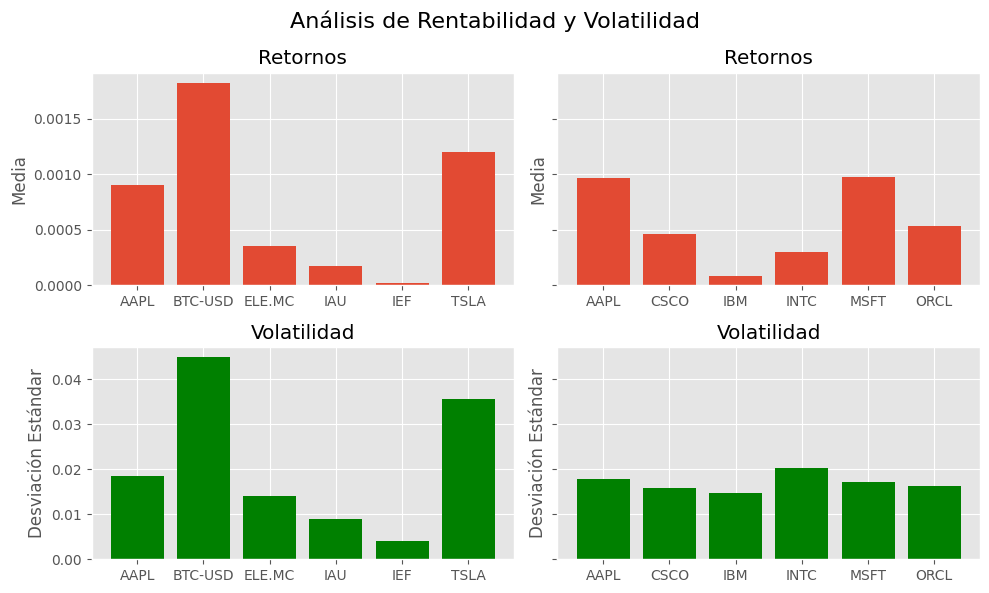

In [5]:
# Crear una figura con dos subplots, uno encima del otro
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey='row')

# Crear el gráfico de barras de los valores medios en la parte superior
axes[0, 0].bar(means.index, means.values)
axes[0, 0].set_ylabel('Media')
axes[0, 0].set_title('Retornos')

# Crear el gráfico de barras de los valores de desviación estándar en la parte inferior
axes[1, 0].bar(stds.index, stds.values,color='green')
axes[1, 0].set_ylabel('Desviación Estándar')
axes[1, 0].set_title('Volatilidad')

#Crear una figura con dos subplots, uno encima del otro
axes[0, 1].bar(means_corr.index, means_corr.values)
axes[0, 1].set_ylabel('Media')
axes[0, 1].set_title('Retornos')

# Crear el gráfico de barras de los valores de desviación estándar en la parte inferior
axes[1, 1].bar(stds_corr.index, stds_corr.values,color='green')
axes[1, 1].set_ylabel('Desviación Estándar')
axes[1, 1].set_title('Volatilidad')

# Añadir un título general a la figura
plt.suptitle('Análisis de Rentabilidad y Volatilidad', fontsize=16)  # Título general

# Ajustar el espaciado entre los subplots para que no se superpongan
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## 2- Cálculo de volatilidad semanal, mensual, anual

Para calcular la volatilidad en un periodo distinto al diario, hay que tener en cuenta que:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\sigma_T = \sqrt{T} * \sigma_{día}$

Luego:

- Volatilidad semanal: $\sigma_{semana} = \sqrt{5} * \sigma_{día}$

- Volatilidad mensual: $\sigma_{mes} = \sqrt{21} * \sigma_{día}$

- Volatilidad anual: $\sigma_{año} = \sqrt{252} * \sigma_{día}$


In [7]:
ret_close_df.head(2)

,AAPL,BTC-USD,ELE.MC,IAU,IEF,TSLA
Date,,,,,,
2014-09-18,0.002065,-0.074643,0.008327,0.002533,-0.000683,0.009292
2014-09-19,-0.008187,-0.072402,0.004727,-0.005920,0.003795,-0.017204


In [9]:
daily_volatility = 100*ret_close_df['AAPL'].std()
print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))

monthly_volatility = math.sqrt(21) * daily_volatility
print ('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))

annual_volatility = math.sqrt(252) * daily_volatility
print ('Annual volatility: ', '{:.2f}%'.format(annual_volatility ))

Daily volatility:  1.84%
Monthly volatility:  8.45%
Annual volatility:  29.27%


## 3- Comparación retornos de activos con distinta volatilidad

VEAMOS AHORA CÓMO SON LOS RETORNOS DIARIOS DE UN ACTIVO CON MUCHA VOLATILIDAD Y CON POCO VOLATILIDAD

In [10]:
# Crear un gráfico de líneas con Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=ret_close_df.loc['2016-05-01':,  :].index, 
                         y=ret_close_df.loc['2016-05-01':,  :]['BTC-USD'], 
                         mode='lines',
                         name='BTC-USD'))

fig.add_trace(go.Scatter(x=ret_close_df.loc['2016-05-01':,  :].index, 
                         y=ret_close_df.loc['2016-05-01':,  :]['IEF'], 
                         mode='lines',
                         name='IEF')) #iShares 7-10 Year Treasury Bond ETF

# Añadir títulos
fig.update_layout(
    title="COMPARACIÓN ACTIVOS CON MUCHA Y POCA VOLATILIDAD",
    title_font=dict(size=24),  # Ajusta el tamaño del título
    title_x=0.5,  # Centra el título
    yaxis_title="Retornos diarios %",
    margin=dict(l=20, r=20, b=20, t=40),  # Ajusta los márgenes para hacer los bordes más pequeños
    height=600,  # Ajusta la altura de la figura
    width = 1400 
)


OTRA FORMA DE VERLO ES CON LA DISTRIBUCIÓN DE LOS RETORNOS DIARIOS

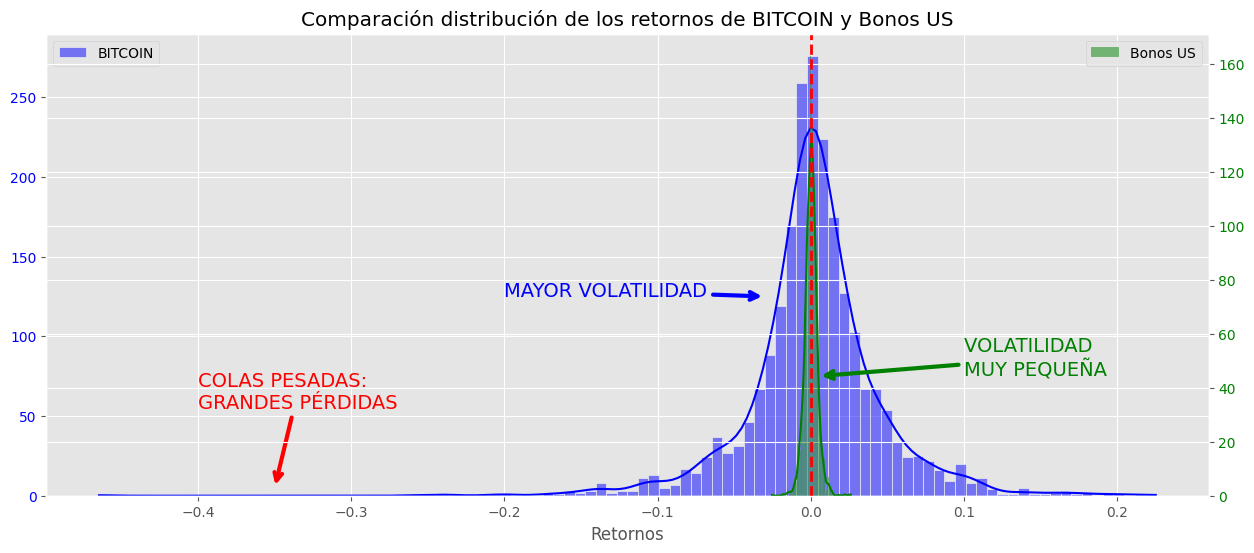

In [11]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# Crear el primer gráfico con sns.histplot
sns.histplot(data=ret_close_df, x='BTC-USD', ax=ax1, bins=100, color='blue', kde=True, alpha=0.5, label='BITCOIN')
ax1.set_xlabel('Retornos')
ax1.set_ylabel('', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# # Añadir texto en ax2
# text_x = -0.4
# text_y = 25

#ax1.text(-0.2, 125, f"MAYOR VOLATILIDAD", fontsize=12, color='blue')

ax1.annotate('MAYOR VOLATILIDAD', xy=(-0.03, 125), xytext=(-0.2, 125),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='blue'),
            fontsize=14, color='blue')

ax1.annotate('VOLATILIDAD \nMUY PEQUEÑA', xy=(0.005, 75), xytext=(0.1, 75),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='green'),
            fontsize=14, color='green')

ax1.annotate('COLAS PESADAS: \nGRANDES PÉRDIDAS', xy=(-0.35, 5), xytext=(-0.4, 55),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='red'),
            fontsize=14, color='RED')



# Duplicar el eje Y para el segundo gráfico
ax2 = ax1.twinx()

# Crear el segundo gráfico con sns.histplot
sns.histplot(data=ret_close_df, x='IEF', ax=ax2, bins=100, color='green', kde=True, alpha=0.5, label='Bonos US')
ax2.set_ylabel('', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

# Añadir una línea vertical en el eje X en 0
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
# Configurar título y mostrar el gráfico
plt.title('Comparación distribución de los retornos de BITCOIN y Bonos US')
plt.show()

## 4- Efecto de usar distintas ventanas temporales para el cálculo de la volatilidad

Vamos a analizar en detalle la volatilidad de los precios de cierre de las acciones de Apple.

Nos decargamos los datos

In [12]:
start_date = "2011-01-04"
end_date = "2021-04-30"

In [13]:
ticker= "aapl"
aapl_df = yf.download(ticker, start=start_date, end=end_date)[['Adj Close']]

[*********************100%%**********************]  1 of 1 completed


In [14]:
aapl_df['Return'] = 100*np.log(aapl_df['Adj Close']).diff()
aapl_df.dropna(inplace=True)

/tmp/ipykernel_53990/4209150725.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_53990/4209150725.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Veamos ahora el efecto de calcular la volatilidad usando distintas ventanas temporales

Si lo calculamos para distintas ventanas temporales móviles:

In [15]:
aapl_df = aapl_df.copy()

aapl_df['Vol_5'] = aapl_df['Return'].rolling(5).std()
aapl_df['Vol_20'] = aapl_df['Return'].rolling(20).std()
aapl_df['Vol_60'] = aapl_df['Return'].rolling(60).std()
aapl_df['Vol_252'] = aapl_df['Return'].rolling(252).std()

In [16]:
aapl_vol = aapl_df.loc[:, ['Vol_5', 'Vol_20', 'Vol_60', 'Vol_252']].dropna()

aapl_vol_filtered = aapl_vol['2016-01-01':'2019-12-31']


In [17]:
# Inicializar la figura
fig = go.Figure()

# Añadir cada columna del DataFrame como una traza
for col in aapl_vol_filtered.columns:
    fig.add_trace(go.Scatter(x=aapl_vol_filtered.index, 
                             y=aapl_vol[col], 
                             mode='lines',
                             name=col))

# Configurar el diseño y mostrar la figura
fig.update_layout(title="Volatilidades de AAPL con distintas ventanas de tiempo",
                    title_font=dict(size=24),  # Ajusta el tamaño del título
                    title_x=0.5,  # Centra el título
                    xaxis_title="Fecha",
                    yaxis_title="Volatilidad")
fig.show()

## 5- Variación temporal de la volatilidad

VEAMOS CóMO VARIA, A LO LARGO DEL TIEMPO, LA VOLATILIDAD DE LOS PRECIOS DE CIERRE DE LAS ACCIONES DE APPLE

In [18]:
# Calculamos las volatilidades en distintos periodos de tiempo

std1 = aapl_df.loc["2016-05-01":"2018-09-01", ['Return']].std()
std2 = aapl_df.loc["2018-09-01":"2020-02-29", ['Return']].std()
std3 = aapl_df.loc["2020-02-29":"2021-04-30", ['Return']].std()

In [19]:
# Crear un gráfico de líneas con Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=aapl_df.loc['2016-05-01':,  :].index, 
                         y=aapl_df.loc['2016-05-01':,  :]['Return'], 
                         mode='lines',
                         name='Return'))


# Añadir anotación para resaltar la baja volatilidad
fig.add_annotation(
    x="2017-07-01",  # Aproximadamente en el medio del período para que el texto aparezca centrado
    #y=stock_data['Return'].max(),  # Esto coloca la anotación cerca del valor máximo de 'Return'. Puedes ajustarlo según tus necesidades.
    y=4,
    text="Baja volatilidad en 2017",
    showarrow=True,
    arrowhead=4,
    ax=0,
    ay=-40,
    arrowsize=2,  # Ajusta el tamaño de la flecha
    font=dict(size=16,  # Ajusta el tamaño de la letra
              color="black"),  # Color de la letra, si lo deseas cambiar
    bgcolor="rgba(255, 227, 227, 0.9)",  # Color de fondo para la anotación
    bordercolor="rgba(255, 0, 0, 0.9)",  # Color del borde para la anotación
    borderwidth=2
)

# Añadir anotación para resaltar la baja volatilidad
fig.add_annotation(
    x="2020-07-01",  # Aproximadamente en el medio del período para que el texto aparezca centrado
    #y=stock_data['Return'].max(),  # Esto coloca la anotación cerca del valor máximo de 'Return'. Puedes ajustarlo según tus necesidades.
    y=7,
    text="Alta volatilidad en 2020",
    showarrow=True,
    arrowhead=4,
    ax=0,
    ay=-70,
    arrowsize=2,  # Ajusta el tamaño de la flecha
    font=dict(size=16,  # Ajusta el tamaño de la letra
              color="black"),  # Color de la letra, si lo deseas cambiar
    bgcolor="rgba(255, 227, 227, 0.9)",  # Color de fondo para la anotación
    bordercolor="rgba(255, 0, 0, 0.9)",  # Color del borde para la anotación
    borderwidth=2
)

# Añadir un segmento horizontal
fig.add_shape(
    type="line",
    x0="2016-05-01",  # Desde el inicio de tus datos
    x1="2018-09-01",  # Hasta finales de febrero de 2020
    y0=2*std1.values[0],
    y1=2*std1.values[0],
    line=dict(color="green", width=2)
)

# Añadir un segmento horizontal
fig.add_shape(
    type="line",
    x0="2016-05-01",  # Desde el inicio de tus datos
    x1="2018-09-01",  # Hasta finales de febrero de 2020
    y0=-std1.values[0],
    y1=-std1.values[0],
    line=dict(color="green", width=2)
)

# Añadir un segmento horizontal
fig.add_shape(
    type="line",
    x0='2018-09-01',  # Desde el inicio de tus datos
    x1="2020-02-29",  # Hasta finales de febrero de 2020
    y0=2*std2.values[0],
    y1=2*std2.values[0],
    line=dict(color="purple", width=2)
)

# Añadir un segmento horizontal
fig.add_shape(
    type="line",
    x0='2018-09-01',  # Desde el inicio de tus datos
    x1="2020-02-29",  # Hasta finales de febrero de 2020
    y0=-2*std2.values[0],
    y1=-2*std2.values[0],
    line=dict(color="purple", width=2)
)

# Añadir un segmento horizontal
fig.add_shape(
    type="line",
    x0='2020-02-29',  # Desde el inicio de tus datos
    x1='2021-04-29',  # Hasta finales de febrero de 2020
    y0=2*std3.values[0],
    y1=2*std3.values[0],
    line=dict(color="red", width=2)
)

# Añadir un segmento horizontal
fig.add_shape(
    type="line",
    x0='2020-02-29',  # Desde el inicio de tus datos
    x1='2021-04-29',  # Hasta finales de febrero de 2020
    y0=-2*std3.values[0],
    y1=-2*std3.values[0],
    line=dict(color="red", width=2)
)

# Añadir etiqueta a la línea
fig.add_annotation(
    text="Las líneas representan ±2σ",
    x='2017-07-01',
    y=-3,
    font=dict(size=18,  # Ajusta el tamaño de la letra
            color="black"),  # Color de la letra, si lo deseas cambiar
    showarrow=True,
    arrowhead=4,
    ax=0,
    ay=50,
    arrowsize=2,  # Ajusta el tamaño de la flecha
    bgcolor="rgba(204, 255, 204, 0.9)",  # Color de fondo verde claro
    bordercolor="rgba(0, 128, 0, 0.9)",  # Color de borde verde oscuro
    borderwidth=2
)


# Añadir títulos
fig.update_layout(
    title="Periodos de volatilidad de Apple",
    title_font=dict(size=24),  # Ajusta el tamaño del título
    title_x=0.5,  # Centra el título
    yaxis_title="Retornos diarios %",
    margin=dict(l=20, r=20, b=20, t=40)  # Ajusta los márgenes para hacer los bordes más pequeños
)

fig.show()


## 6- Interpretación de volatilidad alta y baja

VAmos a analizar qué significa caundo la volatilidad es alta y cuando es baja.

Para ello, vamos a analizar la evolución de precios del índice SP500 y del índice de volatilidad VIV.

In [20]:
# Descargar datos del S&P 500 y VIX
sp500 = yf.download('^GSPC', start="2000-01-01", end="2022-01-01")
vix = yf.download('^VIX', start="2000-01-01", end="2022-01-01")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [27]:


# Crear un gráfico con Plotly
fig = go.Figure()

# Añadir datos del S&P 500 al gráfico (eje y principal)
fig.add_trace(go.Scatter(x=sp500.index, 
                         y=sp500['Close'], 
                         mode='lines',
                         name='S&P 500'))

# Añadir datos del VIX al gráfico (eje y secundario)
fig.add_trace(go.Scatter(x=vix.index, 
                         y=vix['Close'], 
                         mode='lines',
                         name='VIX',
                         yaxis="y2",
                         opacity=0.7))  # Especifica que esta traza debe usar el eje y secundario

# Añadir la anotación solicitada
fig.add_annotation(
    x="2008-07-01",  # Mueve la posición x del texto a 2008
    y=4000,  # Ubicación en el eje y para la anotación
    yref="y1",  # Referencia al eje y principal (S&P 500)
    text="La volatilidad sube cuando el mercado cae",
    font=dict(size=16,  # Ajusta el tamaño de la letra
              color="black"),  # Color de la letra, si lo deseas cambiar
    showarrow=True,  # Muestra la flecha
    arrowhead=2,  # Estilo de la cabeza de la flecha
    arrowsize=1,  # Tamaño de la flecha
    arrowwidth=2,  # Ancho de la flecha
    arrowcolor="#636363",  # Color de la flecha
    axref="x",  # Referencia para la posición ax
    #ayref="y1",  # Referencia para la posición ay
    ax="2004",  # Cambia la dirección de la flecha para que apunte a 2005
    ay=-30,  # Dónde debe apuntar la flecha en el eje y secundario
    bgcolor="rgba(255, 227, 227, 0.9)",  # Color de fondo de la anotación
    bordercolor="rgba(255, 0, 0, 0.9)",  # Color del borde de la anotación
    borderwidth=2  # Ancho del borde de la anotación
)

# Añadir la anotación solicitada
fig.add_annotation(
    x="2020",  # Mueve la posición x del texto a 2008
    y=4000,  # Ubicación en el eje y para la anotación
    yref="y1",  # Referencia al eje y principal (S&P 500)
    text="",
    showarrow=True,  # Muestra la flecha
    arrowhead=2,  # Estilo de la cabeza de la flecha
    arrowsize=1,  # Tamaño de la flecha
    arrowwidth=2,  # Ancho de la flecha
    arrowcolor="#636363",  # Color de la flecha
    axref="x",  # Referencia para la posición ax
    #ayref="y1",  # Referencia para la posición ay
    ax="2007-06-01",  # Cambia la dirección de la flecha para que apunte a 2005
    ay=-30,  # Dónde debe apuntar la flecha en el eje y secundario

)

# Añadir la anotación solicitada
fig.add_annotation(
    x="2015",  # Mueve la posición x del texto a 2008
    y=2500,  # Ubicación en el eje y para la anotación
    yref="y1",  # Referencia al eje y principal (S&P 500)
    text="La volatilidad es baja cuando el mercado sube",
    font=dict(size=16,  # Ajusta el tamaño de la letra
              color="black"),  # Color de la letra, si lo deseas cambiar
    showarrow=True,  # Muestra la flecha
    arrowhead=2,  # Estilo de la cabeza de la flecha
    arrowsize=1,  # Tamaño de la flecha
    arrowwidth=2,  # Ancho de la flecha
    arrowcolor="#636363",  # Color de la flecha
    #axref="x",  # Referencia para la posición ax
    #ayref="y1",  # Referencia para la posición ay
    ax=0,  # Cambia la dirección de la flecha para que apunte a 2005
    ay=-80,  # Dónde debe apuntar la flecha en el eje y secundario
    bgcolor="rgba(255, 227, 227, 0.9)",  # Color de fondo de la anotación
    bordercolor="rgba(255, 0, 0, 0.9)",  # Color del borde de la anotación
    borderwidth=2  # Ancho del borde de la anotación
)

# Configuración del layout del gráfico
fig.update_layout(title="S&P 500 y VIX desde 2000 hasta 2022",
                  title_font=dict(size=24),  # Ajusta el tamaño del título
                  title_x=0.5,  # Centra el título
                  xaxis_title="Fecha",
                  yaxis_title="Precio de cierre S&P 500",
                  yaxis2=dict(title="VIX", 
                              overlaying='y', 
                              side='right'),  # Configuración del eje y secundario
                  height=600,  # Ajusta la altura de la figura
                  width = 1200 # Ajusta el ancho de la figura
                 )

fig.show()


## 7- Características y Predicción de la volatilidad

#### **CARACTERÍSTICAS**

1- **Medida de Riesgo**: 

La volatilidad se utiliza como indicador del riesgo de un activo. Un activo con mayor volatilidad es visto como más arriesgado porque sus rendimientos son menos predecibles.

2- **Agrupación (Clusters)**: 

La volatilidad tiende a agruparse. Los días de altos o bajos rendimientos suelen estar agrupados, lo que significa que períodos de alta volatilidad son seguidos por más períodos de alta volatilidad y viceversa.

3- **Persistencia o Efecto "Memoria"**: 

Esta es una manifestación de autocorrelación en la volatilidad, donde la volatilidad pasada afecta la volatilidad futura.

4- **Asimetría**: 

Los activos a menudo reaccionan de manera diferente a movimientos de precios positivos y negativos. Específicamente, el impacto de los rendimientos sobre la volatilidad suele ser más fuerte en mercados bajistas que en mercados alcistas, especialmente en los mercados de renta variable.

5- **Reacción a Eventos**: 

La volatilidad puede dispararse tras eventos financieros significativos o noticias inesperadas, reflejando la incertidumbre en el mercado.

6- **Reversión a la Media**: 

Aunque es un punto discutible, muchos modelos y observaciones sugieren que la volatilidad tiende a revertir hacia una volatilidad a largo plazo o incondicional. Esta idea fue incorporada en modelos como el ARCH de Robert Engle.



&nbsp;

#### **PREDICCIÓN DE LA VOLATILIDAD**



El **modelo GARCH** (Generalized Autoregressive Conditional Heteroskedasticity) es especialmente adecuado para predecir la volatilidad de los activos financieros debido a cómo aborda las características inherentes de la volatilidad:

1- **Persistencia o Efecto "Memoria":**

GARCH captura la autocorrelación en la volatilidad, permitiendo que la volatilidad de hoy dependa de las volatilidades y shocks pasados. Esto es esencial para modelar la "memoria" o persistencia en la volatilidad.


2- **Agrupación (Clusters):**

Dada su estructura, el modelo GARCH es capaz de capturar los períodos de agrupación en la volatilidad, donde días de alta o baja volatilidad tienden a seguirse.

3- **Asimetría:** 

Algunas variantes del modelo GARCH, como el EGARCH, pueden capturar la asimetría en la volatilidad, reflejando la observación de que los mercados a menudo reaccionan de manera diferente a movimientos de precios positivos y negativos.

4- **Reversión a la Media:** 

La estructura del modelo GARCH implica una reversión a la media, ya que la volatilidad se modela como una combinación de la volatilidad de largo plazo (incondicional) y los efectos de shocks recientes.


&nbsp;

**ECUACIONES MODELO GARCH**

1- Ecuación de los retornos:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$r_t = \mu + \epsilon_t$

donde:
- $r_t$ es el retorno en el instante $t$,

- $\epsilon_t$ es el shock en el instante $t$,


- $\mu$ es la media de los retornos. 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Es un término constante que captura la tendencia central o el "nivel base" de los retornos de un activo o serie temporal. En otras palabras, es el retorno medio o constante que se espera independientemente de los shocks o perturbaciones.


&nbsp;

2 - Ecuación de la Volatilidad:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\sigma_t² = \alpha_0 + \sum_{i=1}^p \alpha_i * \epsilon_{t-i}² + \sum_{j=1}^q \beta_j * \sigma_{t-j}²$

donde:

- $\sigma_t²$ es la varianza de los retornos en el instante $t$,

- $\alpha_0$ es la varianza incondicional de los retornos,

- $\alpha_i$ son los coeficientes que capturan el impacto de los residuos al cuadrado (shocks) pasados en la volatilidad actual,

- $\beta_j$ son los coeficientes que capturan el impacto de la volatilidad pasada en la volatilidad actual,

- $p$ es el orden del modelo AR,

- $q$ es el orden del modelo MA.

&nbsp;

3 - Ecuación de Shock

El residuo o shock $\epsilon_t$ se define en función de la volatilidad condicional y un término de error $z_t$ que sigue una distribución normal estándar:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\epsilon_t = \sigma_t * z_t$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$z_t \sim N(0,1)$




&nbsp;

Si suponemos que los shocks solo dependen del instante anterior, entonces tenemos un modelo GARCH(1,1).


En el caso de un modelo GARCH(1,1) tenemos:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\sigma_t² = \alpha_0 + \alpha_1 * \epsilon_{t-1}² + \beta_1 * \sigma_{t-1}²$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\epsilon_t = \sigma_t * z_t$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$z_t \sim N(0,1)$

- Ecuación de los retornos:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$r_t = \mu + \epsilon_t$


Definimos el modelo GARCH(1,1) y lo ajustamos a los retornos de las acciones de Apple

In [22]:
garch_model = arch_model(aapl_df['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal') # Crear el modelo

gm_result = garch_model.fit(disp='off')
print(gm_result.params) # Imprime los parámetros del modelo

print('\n')

gm_forecast = gm_result.forecast(horizon = 5) # Pronostica 5 periodos hacia adelante
print(gm_forecast.variance[-1:]) # Imprime la varianza pronosticada 

mu          0.168156
omega       0.192923
alpha[1]    0.131226
beta[1]     0.812904
Name: params, dtype: float64


                 h.1       h.2       h.3      h.4       h.5
Date                                                       
2021-04-29  1.689948  1.788453  1.881454  1.96926  2.052159


VAmos a predecir la volatilidad de los retornos de las acciones de Apple usando el modelo GARCH(1,1) para los siguientes 365 días

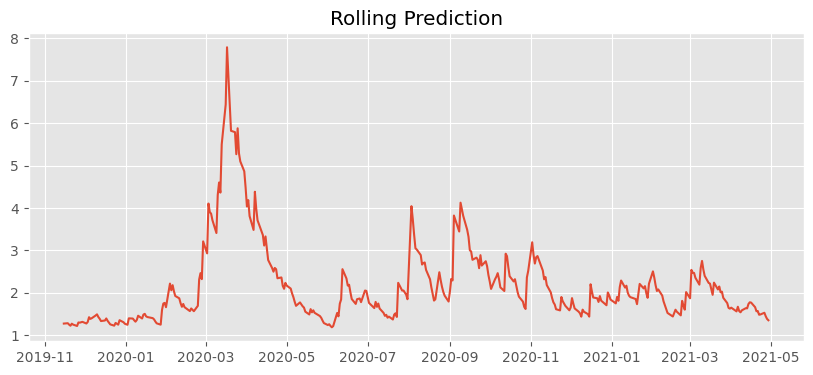

In [23]:
rolling_predictions = [] # Lista para almacenar las predicciones
test_size = 365 # Tamaño del conjunto de prueba

for i in range(test_size):
    train = aapl_df['Return'][:-(test_size-i)] # Entrenar el modelo sin el último valor
    model = arch_model(train, p=1, q=1) # Crear el modelo
    model_fit = model.fit(disp='off') # Ajustar el modelo
    pred = model_fit.forecast(horizon=1)    # Pronosticar un periodo hacia adelante
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0])) # Añadir la predicción a la lista
    
rolling_predictions = pd.Series(rolling_predictions, index=aapl_df['Return'].index[-365:]) # Crear una serie con las predicciones

plt.figure(figsize=(10,4))
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')
plt.show()

In [35]:
# Crear un gráfico con Plotly
fig = go.Figure()

# Añadir datos del S&P 500 al gráfico (eje y principal)
fig.add_trace(go.Scatter(x=aapl_df['Return'][-365:].index, 
                         y=aapl_df['Return'][-365:], 
                         mode='lines',
                         name='AAPL'))

# Añadir datos del VIX al gráfico (eje y secundario)
fig.add_trace(go.Scatter(x=rolling_predictions.index, 
                         y=rolling_predictions, 
                         mode='lines',
                         line=dict(color='red'),
                         name='PREDICCIÓN',
                         opacity=0.7))  

# Añadir datos del VIX al gráfico (eje y secundario)
fig.add_trace(go.Scatter(x=rolling_predictions.index, 
                         y=-rolling_predictions, 
                         mode='lines',
                         line=dict(color='red'),
                         showlegend=False,
                         opacity=0.7))  

# Configuración del layout del gráfico
fig.update_layout(title="PREDICCIÓN DE LA VOLATILIDAD DE AAPL",
                  title_font=dict(size=24),  # Ajusta el tamaño del título
                  title_x=0.5,  # Centra el título
                  xaxis_title="Fecha",
                  yaxis_title="RETORNOS %",
                  height=600,  # Ajusta la altura de la figura
                  width = 1400, # Ajusta el ancho de la figura
                  margin=dict(l=20, r=20, b=30, t=50)
                 )
